In [2]:
"""
Author: Maximilian Gschaider
MN: 12030366
"""
#CC
#https://krasserm.github.io/2018/03/21/bayesian-optimization/
#https://www.borealisai.com/research-blogs/tutorial-8-bayesian-optimization/
#https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html

########################################
#official open-source repositories
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
import sys
#own modules
sys.path.append('../')
from repo_utils import repo_path, fontsize, fontsize_title


%matplotlib inline

bounds = np.array([[-2.0, 3.0]])
#creating nested X array within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
#sample points
X_init = np.array([[-1.5], [2.5]])
noise = 0.2

#test-objective function
def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

Y_init = f(X_init)

#noise-free objective function values at X 
Y = f(X,0)

/tmp/ipykernel_1220335/1884795098.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)


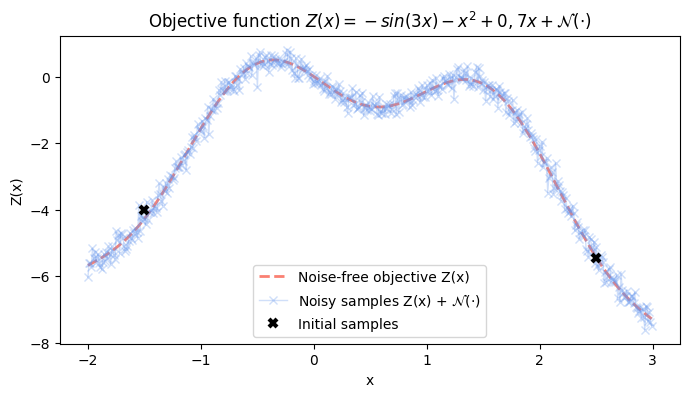

In [5]:
# Plot optimization objective with noise level 
plt.plot(X, Y, color = 'salmon', linestyle = "--", lw=2, label='Noise-free objective Z(x)')
plt.plot(X, f(X), color = 'cornflowerblue', marker = "x", lw=1, alpha=0.3, label='Noisy samples Z(x) + $\mathcal{N}(\cdot)$')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')

plt.xlabel("x", fontsize = fontsize)
plt.ylabel("Z(x)", fontsize = fontsize)
plt.title("Objective function $Z(x) = -sin(3x) - x^2 + 0,7x + \mathcal{N}(\cdot)$", fontsize = fontsize_title)
plt.legend()
fig = plt.gcf()
fig.set_size_inches(8,4)
plt.savefig(repo_path + "/figures/" + "gbm_with_decision_tree_best_parameters.png", dpi=300)

In [19]:
#CC to https://github.com/pradeepsinngh/Bayesian-Optimization/blob/master/bayesian_optimization_util.py
#which enables a plotting schematic of bayesian optimization very comfortable

def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, color = "salmon", ls = '--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, color = 'cornflowerblue', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, color = 'mediumseagreen', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, color = "salmon")
    plt.xlabel('Iteration i')
    plt.ylabel('$\Delta x$')
    plt.title('Distance $\Delta x$ between consecutive $x_i$')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, color = 'cornflowerblue')
    plt.xlabel('Iteration i')
    plt.ylabel('Best function value $\\tilde{F}(x)$')
    plt.title('Values of best selected sample over iterations')

In [4]:
def expected_improvement(X, X_sample, Y_sample, gpr, kappa = 0.01):
    '''
    Calculates the Exptected Improvement (= EI) at the domain points X based on existing samples X_sample
    and Y_sample using a Gaussian process as surrogate model.
    
    Params :
        X : nested array 
            Points at which EI shall be computed (m x d).
        X_sample : array
            Sample locations (n x d).
        Y_sample : array
            Sample values (n x 1).
        gpr : method 
            A GaussianProcessRegressor fitted to samples.
        kappa : scalar
            Exploitation-exploration trade-off parameter.
    
    Returns : array
        Expected improvements (EI) of domain points X.
    '''
    #fitting the whole domain to a Gaussian process
    mu, sigma = gpr.predict(X, return_std=True)
    #fitting the sample domain to a Gaussian process
    mu_sample = gpr.predict(X_sample)
    # Needed for noise-based model, otherwise one can use np.max(Y_sample)
    mu_sample_opt = np.max(mu_sample)

    #calculating the expected improvement (EI) 
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - kappa
        Z = imp / sigma
        #using the cumulative distribution function (CDF) and probability density function (PDF) of a normal distribution
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        #ei at sigma = 0 is zero
        ei[sigma == 0.0] = 0.0
        
    return ei


In [5]:
def propose_next_sampling_point(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts = 10):
    '''
    Proposes the next sampling point by optimizing the acquisition function
    
    Params :
        acquisition : method
            acquisition function with params af(X, X_sample,Y_sample, gpr)
        X_sample : array
            sample locations (n x d).
        Y_sample : array
            sample values (n x 1).
        gpr : method
            GaussianProcessRegressor fitted to samples.

    Returns : array
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    #minimization objective is the negative acquisition function
    def min_objective(X):
        return - acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        #quasi-Newton method of Broyden, Fletcher, Goldfarb, and Shanno (BFGS). It uses the first derivatives only.
        # L-BFGS-B uses the L-BFGS-B algorithm for bound constrained minimization.
        #ref.: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
        res = minimize(min_objective, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            #print(res.fun)
            min_val = res.fun
            min_x = res.x           
            
    return min_x.reshape(-1, 1)


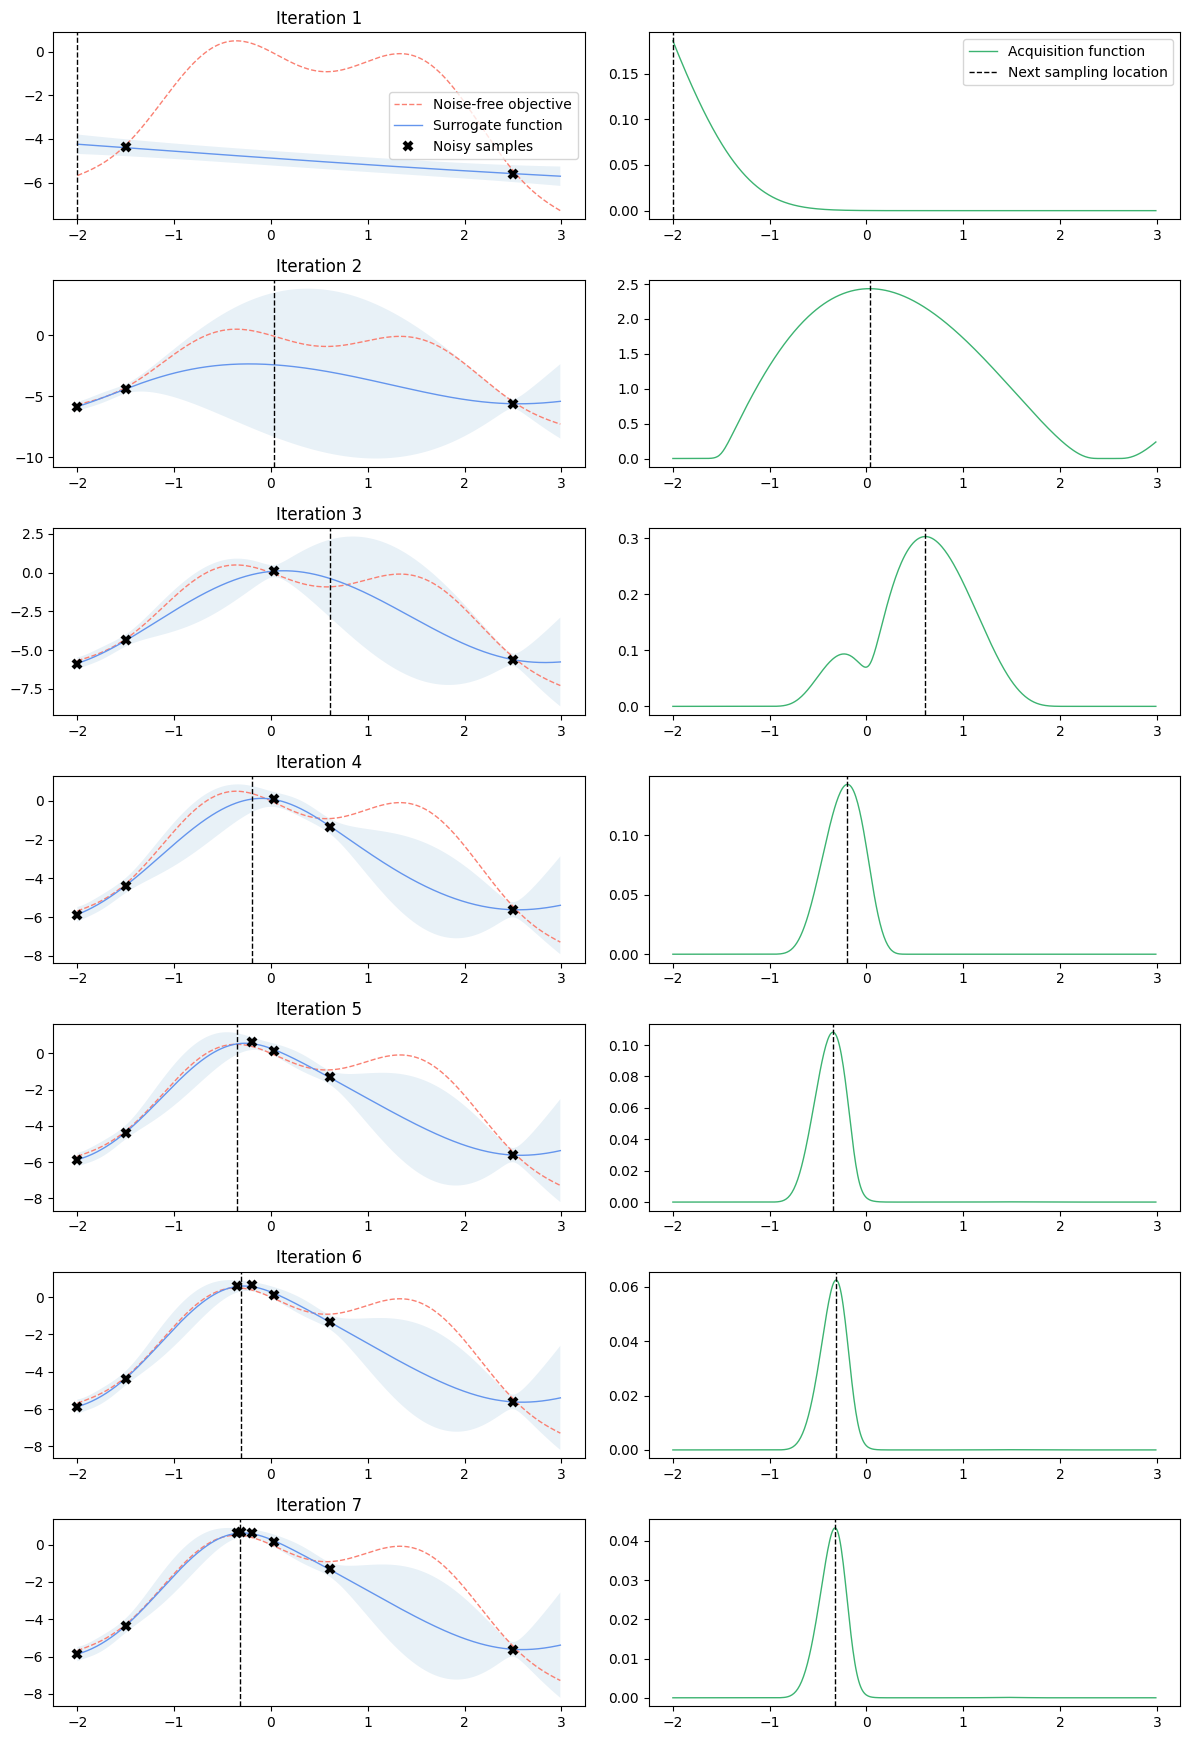

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

#Gaussian process with Matern kernel as surrogate model
#Matern kernel : https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

#Initializing the sample points
X_sample = X_init
Y_sample = Y_init

#Number of iterations which have to be made
n_iter = 7

plt.figure(figsize=(12, n_iter * 2.5))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    #Step 1 : updating the Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    #Step 2 : obtaining the next Sampling Point from the acquisition function (expected_improvement) = (EI)
    X_next = propose_next_sampling_point(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    #Step 3 : obtaining the next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    #Plot the sample points, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}', fontsize = 12)
    #calculating the current expected improvement (EI) for plotting
    ei_ = expected_improvement(X, X_sample, Y_sample, gpr)#[:][-1]
    #plotting acquisition function
    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, ei_, X_next, show_legend=i==0)
    
    #Step 5 : Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

#fig.suptitle(f"Bayesian optimization of scalar objetive function $F(x)$ over {n_iter} iterations with Gaussian Prior")
plt.tight_layout()
plt.savefig("bayesian_optimization_from_scratch_iterations.png", dpi = 300)

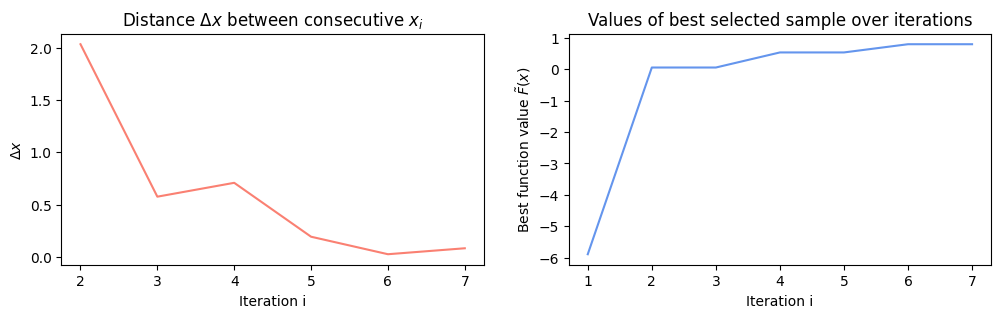

In [13]:
plot_convergence(X_sample, Y_sample)